In [20]:
import glob
import pandas as pd
import numpy as np
from pybaselines import Baseline
from scipy.signal import find_peaks, peak_prominences, peak_widths, savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import re
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

"""
Baseline Correction
"""
def asls_base_corr(spec, lam=1e5, p=0.01):
    """
    Baseline correction with Asymmetric Least Squares
    """
    baseline_fitter = Baseline()
    baseline = baseline_fitter.asls(spec, lam=lam, p=p)[0]
    corrected_spec = spec - baseline
    return corrected_spec, baseline

def savgol_base_corr(spectrum, window_length=101, polyorder=5):
    """
    Baseline Correction with Savitzky-Golay filter
    **** Poly order 5
    """
    if window_length > len(spectrum):
        window_length = len(spectrum) // 2 * 2 + 1

    baseline = savgol_filter(spectrum, window_length=window_length, polyorder=polyorder)
    corrected_spectrum = spectrum - baseline

    return corrected_spectrum, baseline


"""
Normalization
"""
def normalization(spec, type=None):
    """
    adjusts spectrums to a common scale
    """
    if type == None:
        return spec
    elif type == "z_score":
        return (spec - spec.mean()) / spec.std()
    elif type == "min_max":
        return (spec - spec.min()) / (spec.max() - spec.min())
    else:
        return spec

In [30]:
files =glob.glob('/Users/rmock32/Library/CloudStorage/Box-Box/RAB-ML/phase-b/chemistry/data/ftir/production/raw/*.CSV')
file_prefixes = [os.path.basename(file).split("-")[0] for file in files]
file_names = [os.path.basename(file) for file in files]

df_raw = pd.DataFrame()
col = []
print(f"len(files): {len(files)}")
print(f"len(file_prefixes): {len(file_prefixes)}")

for file in files:
    if file.lower().endswith(".csv"):
        temp_df = pd.read_csv(file)
        if temp_df.shape[1] > 1:
            col.append(temp_df.iloc[:, 1].rename(file))

df_raw = pd.concat(col, axis=1)
df_raw.columns = file_names
df = df_raw.copy()

for i in range(len(df.columns)):
    temp_df = df.iloc[:, i]
    corr_spec, base = asls_base_corr(temp_df)
    df.iloc[:, i] = corr_spec

# df_mean = df.mean()
# df_std = df.std()
# df = (df - df_mean) / df_std

print(df.shape)

def assign_label(sample_number):
    if 1 <= sample_number <= 4:
        return 1.1
    if 5 <= sample_number <= 10:
        return 1.2
    if 11 <= sample_number <= 30:
        return 2
    elif 31 <= sample_number <= 36:
        return 3.1
    elif 37 <= sample_number <= 39:
        return 3.2
    elif 40 <= sample_number <= 46:
        return 3.3
    elif 47 <= sample_number <= 50:
        return 3.4

sample_numbers = [int(re.match(r'i(\d+)', prefix).group(1)) for prefix in file_prefixes]
label_vec = [assign_label(number) for number in sample_numbers]
df = df.T

label_vec = np.array(label_vec)
if label_vec.ndim == 2 and label_vec.shape[1] == 1:
    label_vec = label_vec.flatten()

label_vec = pd.Series(label_vec)
df = df.reset_index(drop=True)
label_vec = label_vec.reset_index(drop=True)


subclass_labels = label_vec.astype(str)
parent_labels = subclass_labels.str.split('.').str[0].astype(str)


X = StandardScaler().fit_transform(df.values)

def comp_means(X, labels):
    classes = np.unique(labels)
    means = {}
    for c in classes:
        means[c] = np.mean(X[labels == c], axis=0)
    return means

global_mean = np.mean(X, axis=0)
subclass_means = comp_means(X, subclass_labels)
parent_means = comp_means(X, parent_labels)

n_features = X.shape[1]
S_WS = np.zeros((n_features, n_features))
S_BS = np.zeros((n_features, n_features))
S_B = np.zeros((n_features, n_features))

for s in np.unique(subclass_labels):
    idx = subclass_labels == s
    x_s = X[idx]
    mu_s = subclass_means[s]
    S_WS += (x_s - mu_s).T @ (x_s - mu_s)

    p = s.split('.')[0]
    mu_p = parent_means[p]
    n_s = x_s.shape[0]
    diff = (mu_s - mu_p).reshape(-1, 1)
    S_BS += n_s * diff @ diff.T

for p in np.unique(parent_labels):
    idx = parent_labels == p
    x_p = X[idx]
    mu_p = parent_means[p]
    n_p = x_p.shape[0]
    diff = (mu_p - global_mean).reshape(-1, 1)
    S_B += n_p * diff @ diff.T
    
from scipy.linalg import eigh

alpha = 0.5
reg = 1e-8
S_W_h = alpha * S_WS + (1 - alpha) * S_BS + reg * np.eye(S_WS.shape[0])

eigvals, eigvecs = eigh(S_B, S_W_h)
W = eigvecs[:, np.argsort(eigvals)[::-1][:2]]  # 2D projection
X_proj = X @ W


len(files): 150
len(file_prefixes): 150
(3629, 150)


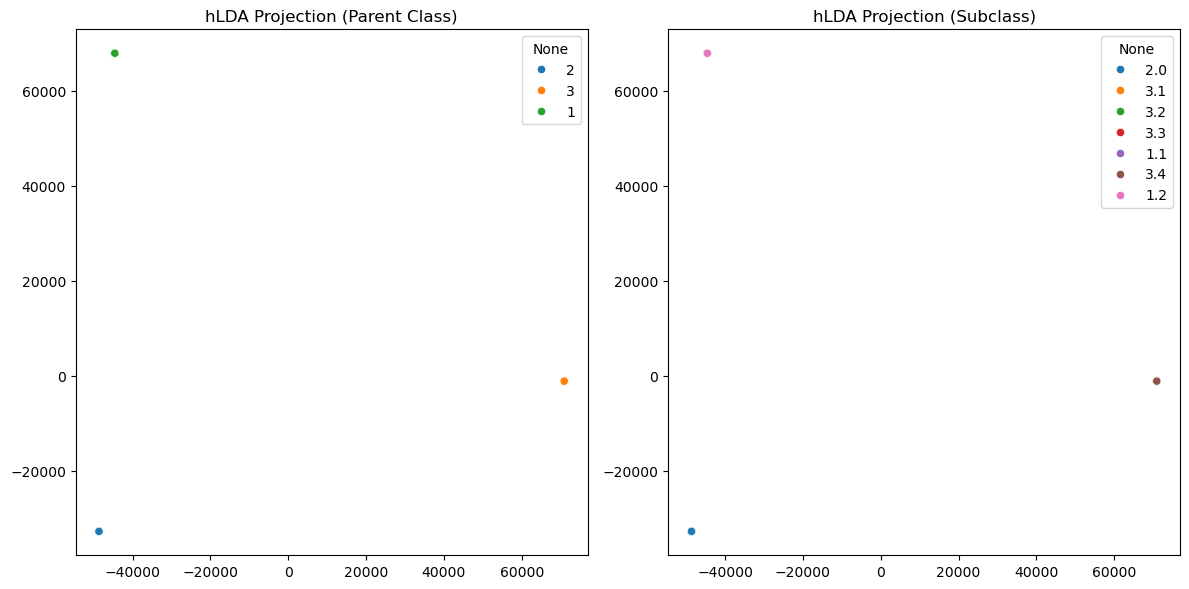

In [35]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=parent_labels)
plt.title("hLDA Projection (Parent Class)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=subclass_labels)
plt.title("hLDA Projection (Subclass)")
plt.tight_layout()
plt.show()


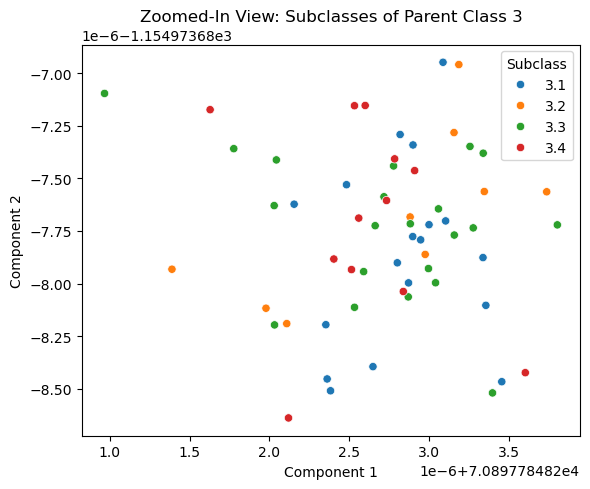

In [38]:
mask = parent_labels == '3'
X_zoom = X_proj[mask]
sub_zoom = subclass_labels[mask]

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_zoom[:, 0], y=X_zoom[:, 1], hue=sub_zoom)
plt.title("Zoomed-In View: Subclasses of Parent Class 3")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Subclass")
plt.tight_layout()
plt.show()